In [1]:
import pandas as pd
import numpy as np
from numpy.random import normal as normal
from math import cos, sin
from matplotlib import animation

from scipy.integrate import odeint
from scipy.integrate import solve_ivp

from matplotlib import pyplot as plt

In [141]:
def randomConfig(mass, number_of_dim, test, test_counter):
    # for dim == 2 return [mass, px, py, vx, vy], note that p stands for position not momenta
    if test:
        if test_counter == 0:
            print('initialize body ', test_counter)
            return np.array([mass, 1, -1, 0,  2.5]) # body1
        elif test_counter == 1:
            print('initialize body ', test_counter)
            return np.array([mass, -1, 1, 2.5, 0]) # body2
        else:
            print('initialize body ', test_counter)
            return np.array([mass, -0, 0, -1.5,  -1.5]) # body3
    else:
        #print('initialize body ', test_counter+1)
        positions = np.squeeze(normal(0, 7.5, size=(1, 3)))
        velocities = np.squeeze(normal(0, 2., size=(1, 2)))
        body = np.hstack([positions, velocities])
        body[0] = mass
        
        return body

In [186]:
# define important parameters
G = 10.
nbodies = 5
ndim = 2
mass = 10

In [193]:
def get_accelerations2(state, epsilon=0.025):
    
    nbodies = state.shape[0]
    
    net_accs = []
    
    for i in range(nbodies):
        #print('--> compute all for body ', i)
        
        # get all bodies except body i
        other_bodies = np.concatenate([state[:i,:], state[i+1:,:]], axis=0)
        
        
        # compute displacements 
        displacements = other_bodies[:,1:3] - state[i,1:3]
        
        
        # compute distances
        distances = (displacements**2).sum(1, keepdims=True)**0.5
         
        # get masess
        masses = other_bodies[:,0:1].reshape(nbodies - 1, -1)

        
        # compute pointwise accelerations        
        pointwise_accs = G * masses * displacements  / (distances**3 + epsilon) 

        
        # compute net_acc's (accleration of body i in each dim)
        net_acc = pointwise_accs.sum(0, keepdims=True)
        #print('net_acc \n', net_acc)
        
        net_accs.append(net_acc)

    net_accs = np.concatenate(net_accs, axis=0)
    
    return net_accs

In [194]:
def update_states(t, state):

    #print('update_states:state \n', state)
    state = state.reshape(-1, 2 * ndim + 1)

    
    #print('update_states:state \n', state)
    
    #print('   m0,  px,  py,  vx,  vy')
    derivs = np.zeros_like(state)
    #derivs[:,0] = state[:,0]
    derivs[:,1:3] = state[:,3:5]
    
    
    derivs[:,3:5] = get_accelerations2(state)

    
      

    #print('derivs \n', derivs)
    
    return derivs.reshape(-1)

In [195]:
def rk4(func, y0, t, h):
    
    #print('rk4:y0 \n', y0)
    
    y_next = np.zeros_like(y0)
    
    #return 0
    
    k1 = func(t, y0)    
    #print('k1 \n', k1)
    
    k2 = func(t + h * 0.5, y0 + k1 * 0.5 * h)    
    #print('k2 \n', k2)
    
    k3 = func(t + h * 0.5, y0 + k2 * 0.5 * h)
    #print('k3 \n', k3)
    
    k4 = func(t + h, y0 + k3 * h)
    #print('k4 \n', k4)
    
    v = y0 + h * (k1 + 2 * k2 + 2 * k3 + k4) / 6

    # p doesn't explicitly depend on other variables
    k1 = k2 = k3 = k4 = v

    p = y0 + h * (k1 + 2 * k2 + 2 * k3 + k4) / 6
    
    #print('v \n', v)
    #print('p \n', p)
    
    y0 = y0.reshape(-1, 2 * ndim + 1)
    v = v.reshape(-1, 2 * ndim + 1)
    p = p.reshape(-1, 2 * ndim+ 1)    
    y_next = y_next.reshape(-1, 2 * ndim + 1)
    
    # overtake mass
    y_next[:,0] = y0[:,0]
    
    # update velocities
    y_next[:,3:] = v[:,3:]
    
    # update positions
    y_next[:,1:3] = v[:,1:3]
    #print('y_next \n', y_next)
    
    return y_next
    #return np.array([u, v])

In [196]:
# time intervall
t_span = [0,20]
t_points = 1000
t_eval = np.linspace(t_span[0], t_span[1], t_points)
h = (t_span[1] - t_span[0]) / (t_points - 1)

states = np.zeros(shape=(t_points+1, nbodies, 2 * ndim + 1)) #2 because of postion and velocity, +1 because of mass

# initializing state0
for i in range(states.shape[1]):
    states[0,i,:] = randomConfig(mass, ndim, False, i)


# get solution from rk4
progress = []

# build the driver
for step in range(len(t_eval)):
    percents = int(t_eval[step] / t_eval[-1]  * 100)
    if percents % 10 == 0:
        if percents not in progress:
            progress.append(percents)
            print('--> progress: {}%'.format(percents))
    
    states[step+1] = rk4(update_states, states[step].flatten(), t_eval[step], h)

--> progress: 0%
--> progress: 10%
--> progress: 20%
--> progress: 30%
--> progress: 40%
--> progress: 50%
--> progress: 60%
--> progress: 70%
--> progress: 80%
--> progress: 90%
--> progress: 100%


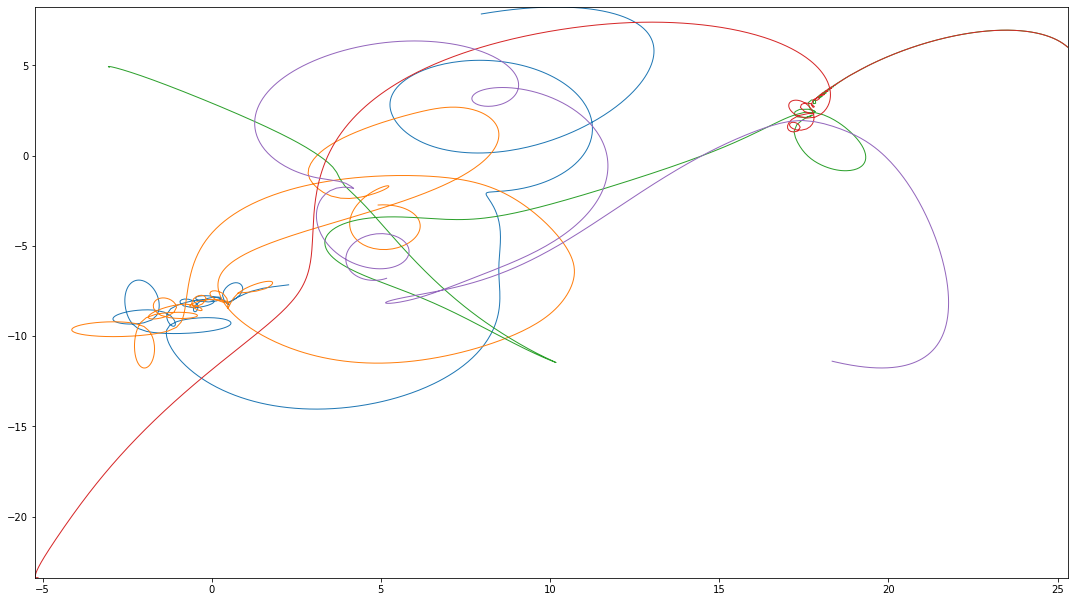

In [198]:
# First set up the figure, the axis, and the plot element we want to animate
fig = plt.figure()
fig.set_size_inches(18.5, 10.5)

xmin = np.min([x for x in states[:, :, 1]])
xmax = np.max([x for x in states[:, :, 1]])

ymin = np.min([x for x in states[:, :, 2]])
ymax = np.max([x for x in states[:, :, 2]])

lim = 50
ax = plt.axes(xlim=(xmin, xmax), ylim=(ymin, ymax))
#ax = plt.axes(xlim=(-lim, lim), ylim=(-lim, lim))

lines = []
for body in range(nbodies):
    lines.append(ax.plot([], [], lw=1))


frame_num = states.shape[0]

# initialization function: plot the background of each frame
def init():
    for line in lines:
        line[0].set_data([], [])
    
    return lines[0]

x_list = [[] for i in range(nbodies)]
y_list = [[] for i in range(nbodies)]

# animation function.  This is called sequentially
def animate(i):
    #return 0

    for j in range(nbodies):
        x_list[j].append(states[i, j, 1])
        y_list[j].append(states[i, j, 2])
    
    for j in range(len(lines)):
        lines[j][0].set_data(x_list[j], y_list[j])
        
    return [line[0] for line in lines]

# call the animator.  blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animate, init_func=init, frames=frame_num, interval=20, blit=True)

anim.save('solve_rk4_cubic.mp4')
plt.show()